In [13]:
import pandas as pd
import numpy as np
import itertools as it
import os
import io
import logging

import boto3
import sys
import json
import snowflake.connector

# Reading Data 

In [14]:
## WRITE OR READ FROM S3 ####
import boto3
import io

s3 = boto3.resource('s3')
output_bucket = "hbo-outbound-datascience-content-dev"
input_bucket = "hbo-ingest-datascience-content-dev"
bucket = s3.Bucket(input_bucket)

def write_to_sf(df, file_name):
    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index = False)
    content = csv_buffer.getvalue()
    filename = 'title_hours_viewed_retention/{}.csv'.format(file_name)
    client = boto3.client('s3')
    client.put_object(Bucket=output_bucket, Key=filename, Body=content)
    
def write_to_input(df, file_name):
    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index = False)
    content = csv_buffer.getvalue()
    filename = 'title_hours_viewed_retention/{}.csv'.format(file_name)
    client = boto3.client('s3')
    client.put_object(Bucket=input_bucket, Key=filename, Body=content)
    
def read_from_s3(filename, input_bucket = input_bucket):
    for obj in bucket.objects.filter(Prefix=filename): #churn_metric_0811
            key = obj.key 
            body = obj.get()['Body']
            print('Reading {0} features'.format(key))
            df = pd.read_csv(body, na_values = [r'\\\\N'])
    return df

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [15]:
churn_metric = read_from_s3('cost_allocation/dev/churn_metric_0906')
churn_metric.head()

Reading cost_allocation/dev/churn_metric_0906.csv features


,Unnamed: 0,genre,medal,category,churn_per_hr_person
0,0,action,Platinum,movies,-0.028358
1,1,action,Gold,series,-0.020530
2,2,action,Gold,movies,-0.027117
3,3,action,Silver,series,-0.005406
4,4,action,Silver,movies,-0.019190


In [16]:
hours_viewed = read_from_s3('title_hours_viewed_retention/content_slate_metadata_level.csv')

Reading title_hours_viewed_retention/content_slate_metadata_level.csv features


In [17]:
hours_viewed = hours_viewed.reset_index()

In [18]:
# hours_viewed = hours_viewed[['prediction', 'genre', 
#                              'medal', 'content_category', 'asset_run_time_hours', 'index']]

In [19]:
hours_viewed.rename(columns = {'content_category':'category', 'index':'name_number'}, inplace = True)

In [20]:
# hours_viewed.loc[(hours_viewed['genre'].isin(['action', 'other'])) & (hours_viewed['medal']=='Platinum')
#                 &(hours_viewed['category']=='series'), 'genre'] = 'comedy'

In [21]:
hours_viewed = hours_viewed.merge(churn_metric[['genre','medal','category', 'churn_per_hr_person']], on = ['genre','medal','category'],
                                 how = 'left')

In [22]:
hours_viewed['change_in_churn_60d_prediction'] = hours_viewed['prediction'] * hours_viewed['churn_per_hr_person']

In [23]:
hours_viewed_thresh = hours_viewed

In [24]:
len(hours_viewed_thresh)

59

# Allocate the 60-Day Churn to monthly

In [25]:
ever_green_titles = read_from_s3('title_hours_viewed_retention/final_evergreen_title_list.csv') #final_evergreen_title_list.csv # ever_green_titles.csv

Reading title_hours_viewed_retention/final_evergreen_title_list.csv features


In [26]:
# ever_green_title_name = ever_green_titles.title_name.unique()
# norm_title_name = hours_viewed_thresh[~hours_viewed_thresh['title_name'].isin(ever_green_title_name)].title_name.unique()

### 1. Normal Titles

In [27]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

Matplotlib is building the font cache; this may take a moment.


In [28]:
from scipy.optimize import curve_fit

In [29]:
historical_weekly_hours_viewed = read_from_s3('title_hours_viewed_retention/historical_weekly_hours_viewed.csv')

Reading title_hours_viewed_retention/historical_weekly_hours_viewed.csv features


In [30]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

In [31]:
train_data = historical_weekly_hours_viewed.copy()
##### TRAIN FOR MOVIE ############
x1 = (train_data[train_data['content_category'] == 'movies']['days_on_hbo_max'])
y1 = train_data[train_data['content_category'] == 'movies']['target']
popt1, pcov1 = curve_fit(func, x1, y1)

##### TRAIN FOR SERIES ############
x2 = (train_data[train_data['content_category'] == 'series']['days_on_hbo_max'])
y2 = train_data[train_data['content_category'] == 'series']['target']
popt2, pcov2 = curve_fit(func, x2, y2)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [32]:
x = pd.Series(np.arange(0,150,1))
y1 = func(x, *popt1)
y2 = func(x, *popt2)

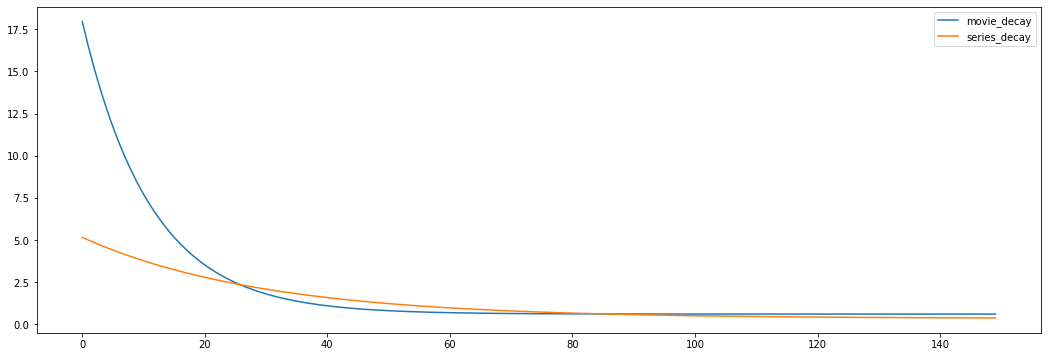

In [33]:
fig, ax = plt.subplots(figsize=(18, 6))
plt.plot(x, y1, label = 'movie_decay')
plt.plot(x, y2, label = 'series_decay')

plt.legend()
plt.show()

In [34]:
dt_df_movie = pd.DataFrame({'days_on_hbo_max': x,
                           'factor': y1,
                           'content_category': 'movies'})
dt_df_series = pd.DataFrame({'days_on_hbo_max': x,
                           'factor': y2,
                           'content_category': 'series'})
dt_df = pd.concat([dt_df_movie, dt_df_series], axis = 0)
dt_df.rename(columns = {'content_category':'category'}, inplace = True)

In [35]:
day_60_cum_sum = dt_df[dt_df['days_on_hbo_max']<60].groupby(['category']).factor.sum().reset_index()

In [36]:
hours_viewed_decay_norm = hours_viewed_thresh

hours_viewed_decay_norm = hours_viewed_decay_norm.merge(dt_df, on = ['category'])\
                                                 .merge(day_60_cum_sum.rename(columns = {'factor':'cum_sum'}), on = ['category'])

hours_viewed_decay_norm['change_in_churn_prediction'] = hours_viewed_decay_norm['change_in_churn_60d_prediction']/hours_viewed_decay_norm['cum_sum']*hours_viewed_decay_norm['factor']*hours_viewed_decay_norm['asset_run_time_hours']

# hours_viewed_decay_norm['request_date'] = pd.to_datetime(hours_viewed_decay_norm['offering_start_date']) \
#                                         + pd.to_timedelta(hours_viewed_decay_norm['days_on_hbo_max'], unit='D')

### 2. Evergreen Titles

#### 2.2 Keep the retention value all the way along

In [37]:
# dt_df = pd.DataFrame()
# dt_df['days_on_hbo_max'] = [i for i in range(0, 365*3, 1)]
# dt_df['key'] = 1

# hours_viewed_decay_evergreen = hours_viewed_thresh[hours_viewed_thresh['title_id'].isin(ever_green_title_id)]
# hours_viewed_decay_evergreen['key'] = 1

# hours_viewed_decay_evergreen = hours_viewed_decay_evergreen.merge(dt_df, on = ['key']).drop(['key'], axis = 1)

# hours_viewed_decay_evergreen['change_in_churn'] = hours_viewed_decay_evergreen['change_in_churn_60d']/60*hours_viewed_decay_evergreen['asset_run_time_hours']
# hours_viewed_decay_evergreen['change_in_churn_prediction'] = hours_viewed_decay_evergreen['change_in_churn_60d_prediction']/60*hours_viewed_decay_evergreen['asset_run_time_hours']

# hours_viewed_decay_evergreen['request_date'] = pd.to_datetime(hours_viewed_decay_evergreen['offering_start_date']) \
#                                         + pd.to_timedelta(hours_viewed_decay_evergreen['days_on_hbo_max'], unit='D')

# hours_viewed_decay_evergreen = hours_viewed_decay_evergreen[hours_viewed_decay_evergreen['request_date'] <= '2023-03-01']


In [38]:
# fig, ax = plt.subplots(figsize=(8, 4))
# test = hours_viewed_decay_evergreen


# for i in range(1,2,1):
#     plot_df = test[(test['title_name'] == 'Friends') &(test['season_number'] == i)]
#     plt.plot(plot_df['days_on_hbo_max'], plot_df['change_in_churn'], label= 'Actual - Friends S' + str(i))
#     plt.plot(plot_df['days_on_hbo_max'], plot_df['change_in_churn_prediction'], label= 'Prediction - Friends S' + str(i))

# ax.set_xlabel('days_on_hbo_max')
# ax.set_ylabel('change_in_churn')
# ax.legend()

# plt.show()

## UNION ALL THE DFs

In [39]:
# data = pd.concat([hours_viewed_decay_norm[['title_name', 'title_id', 'season_number', 'request_date',  'days_on_hbo_max', 'change_in_churn', 'change_in_churn_prediction']],
#                 hours_viewed_decay_evergreen[['title_name', 'title_id', 'season_number', 'request_date',  'days_on_hbo_max', 'change_in_churn', 'change_in_churn_prediction']] ],
#                 axis = 0)
data = hours_viewed_decay_norm

In [40]:
data.head()

,name_number,asset_run_time_hours,category,program_type,medal,genre,is_pay_1,hit_series,medal_number,content_category_movies,...,genre_drama,sig_pred,logged_pred,prediction,churn_per_hr_person,change_in_churn_60d_prediction,days_on_hbo_max,factor,cum_sum,change_in_churn_prediction
0,0,1.630258,movies,acquired,Bronze,other,0,0,3.0,1,...,0,0,-5.64167,0.02003,-0.033936,-0.00068,0,17.958630,239.07981,-0.000083
1,0,1.630258,movies,acquired,Bronze,other,0,0,3.0,1,...,0,0,-5.64167,0.02003,-0.033936,-0.00068,1,16.478661,239.07981,-0.000076
2,0,1.630258,movies,acquired,Bronze,other,0,0,3.0,1,...,0,0,-5.64167,0.02003,-0.033936,-0.00068,2,15.124960,239.07981,-0.000070
3,0,1.630258,movies,acquired,Bronze,other,0,0,3.0,1,...,0,0,-5.64167,0.02003,-0.033936,-0.00068,3,13.886754,239.07981,-0.000064
4,0,1.630258,movies,acquired,Bronze,other,0,0,3.0,1,...,0,0,-5.64167,0.02003,-0.033936,-0.00068,4,12.754190,239.07981,-0.000059


In [41]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#### Write to S3/SF

In [42]:
filename = 'content_slate_metadata_level_'+pd.Timestamp.today().strftime('%Y-%m-%d') 

In [43]:
data.columns

Index(['name_number', 'asset_run_time_hours', 'category', 'program_type',
       'medal', 'genre', 'is_pay_1', 'hit_series', 'medal_number',
       'content_category_movies', 'content_category_series',
       'program_type_acquired', 'program_type_original', 'genre_action',
       'genre_comedy', 'genre_drama', 'sig_pred', 'logged_pred', 'prediction',
       'churn_per_hr_person', 'change_in_churn_60d_prediction',
       'days_on_hbo_max', 'factor', 'cum_sum', 'change_in_churn_prediction'],
      dtype='object')

In [44]:
data = data[['genre', 'medal', 'category', 'is_pay_1', 'hit_series',  'program_type', 'days_on_hbo_max',
            'asset_run_time_hours', 'churn_per_hr_person', 'change_in_churn_prediction']]

In [45]:
write_to_sf(data,  filename)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning:

Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/



In [46]:
len(data)

8850

In [47]:
output_bucket+'/title_hours_viewed_retention/{}.csv'.format(filename)

'hbo-outbound-datascience-content-dev/title_hours_viewed_retention/content_slate_metadata_level_2023-11-10.csv'

In [48]:
data.to_csv('content_slate_metadata_level.csv')

In [88]:
# pivot_table = pd.pivot_table(data, values='change_in_churn_prediction', 
#                              index=['title_name', 'name_number', 'offering_start_date'],
#                            columns=['date_month'], aggfunc="sum", fill_value=np.NaN)

In [89]:
len(pivot_table)

726

In [90]:
pivot_table.to_csv('MoM Content Slate Retention Value.csv')